In [1]:
import json
import os
import numpy as np
from keras.models import Model,load_model
from keras.layers import Input, LSTM, Dense,Activation
from keras.layers.core import Lambda
import numpy as np
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from nltk.translate.bleu_score import sentence_bleu
from keras.callbacks import EarlyStopping
import random
from PIL import Image
from matplotlib import pyplot as plt
import pickle


Using TensorFlow backend.


In [2]:
coco_json='./data/dataset_coco.json'

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
KTF.set_session(session)

In [3]:
with open(coco_json) as file:
    lines=file.readlines()
data=json.loads(lines[0])['images']

{'filepath': 'val2014', 'imgid': 0, 'sentences': [{'imgid': 0, 'raw': 'A man with a red helmet on a small moped on a dirt road. ', 'sentid': 770337, 'tokens': ['a', 'man', 'with', 'a', 'red', 'helmet', 'on', 'a', 'small', 'moped', 'on', 'a', 'dirt', 'road']}, {'imgid': 0, 'raw': 'Man riding a motor bike on a dirt road on the countryside.', 'sentid': 771687, 'tokens': ['man', 'riding', 'a', 'motor', 'bike', 'on', 'a', 'dirt', 'road', 'on', 'the', 'countryside']}, {'imgid': 0, 'raw': 'A man riding on the back of a motorcycle.', 'sentid': 772707, 'tokens': ['a', 'man', 'riding', 'on', 'the', 'back', 'of', 'a', 'motorcycle']}, {'imgid': 0, 'raw': 'A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. ', 'sentid': 776154, 'tokens': ['a', 'dirt', 'path', 'with', 'a', 'young', 'person', 'on', 'a', 'motor', 'bike', 'rests', 'to', 'the', 'foreground', 'of', 'a', 'verdant', 'area', 'with', 'a', 'bridge', 'and', 'a', 'background', 'of', 'cloud', 'wreathed', 'mountains']}, {'imgid': 0, 'raw': 'A man in a red shirt and a red hat is on a motorcycle on a hill side.', 'sentid': 781998, 'tokens': ['a', 'man', 'in', 'a', 'red', 'shirt', 'and', 'a', 'red', 'hat', 'is', 'on', 'a', 'motorcycle', 'on', 'a', 'hill', 'side']}], 'split': 'test', 'cocoid': 391895, 'sentids': [770337, 771687, 772707, 776154, 781998], 'filename': 'COCO_val2014_000000391895.jpg'}

In [4]:
train_x_file=[]
train_y_seq=[]
vali_x_file=[]
vali_y_seq=[]
token={}
if os.path.exists('token.pkl'):
    with open('token.pkl','rb') as file:
        token=pickle.load(file)
else:
    token['\t']=0
    token['\n']=1

In [5]:
for d in data:
    if d['split']=='train':
        train_x_file.append('./coco/'+d['filepath']+'/'+d['filename'])
        seq=d['sentences'][0]['tokens']
        for s in seq:
            if s not in token:
                token[s]=len(token)
        train_y_seq.append(['\t']+seq+['\n'])
    if d['split']=='test':
        vali_x_file.append('./coco/'+d['filepath']+'/'+d['filename'])
        seq=d['sentences'][0]['tokens']
        for s in seq:
            if s not in token:
                token[s]=len(token)
        vali_y_seq.append(['\t']+seq+['\n'])

In [6]:
with open('token.pkl','wb') as file:
    pickle.dump(token,file)
    
num_tokens=len(token)
batch_size=64
seq_len=49+2 #49+'\t'+'\n'
vec_len=173056
print("Num of train:",len(train_x_file))
print("Num of vali:",len(vali_x_file))
print("Num of token:",num_tokens)
print("Len of vector:",vec_len)


Num of train: 82783
Num of vali: 5000
Num of token: 11857
Len of vector: 173056


In [7]:
def vec_reader(path):
    with open(path,'r') as f:
        line=f.readline()
        vector=np.asarray( list(map(float,line.split(",")[1].split(" "))) )
    return vector

In [8]:
def dataGenerator(x,y):
    index=0
    while(1):
        decoder_input_data=[]
        decoder_target_data=[]
        encoder_input_data=[]
        for i in range(batch_size):
            for t,word in enumerate(y[index]):
                if t>0:
                    eid=np.zeros(
                        (1,vec_len),dtype='float32'
                    )
                    did=np.zeros(
                        (seq_len),dtype='float32'
                    )
                    dtd=np.zeros(
                        (num_tokens),dtype='float32'
                    )
                    eid[i][0]=vec_reader(x[index]+'.txt')
                    ecoder_input_data.append(eid)
                    for tt in range(t):
                        did[tt]=float(token[y[index][tt]])
                    dtd[token[y[index][t]]=1.
                    decoder_input_data.append(did)
                    decoder_target_data.append(dtd)
            index+=1
            if index==len(y)-1:
                index=0
        yield ([np.array(encoder_input_data),np.array(decoder_input_data)],np.array(decoder_target_data))

In [10]:
latent_dim=128
encoder_inputs=Input(shape=(None,vec_len))
#encoder_dense=Dense(latent_dim)(encoder_inputs)
encoder=LSTM(latent_dim,return_state=True)
encoder_outputs,state_h,state_c=encoder(encoder_inputs)
encoder_states=[state_h,state_c]

decoder_inputs=Input(shape=(None,seq_len))
decoder_embed=Embedding(num_tokens,latent_dim,input_length=seq_len)
decoder_lstm=LSTM(latent_dim,return_sequences=True,return_state=True)
decoder_outputs,_,_=decoder_lstm(decoder_embed(decoder_inputs),initial_state=encoder_states)
decoder_dense=Dense(num_tokens) #,activation='softmax'
decoder_weighted=Lambda((lambda x: x/1))
decoder_softmax=Activation('softmax')
decoder_outputs=decoder_softmax(decoder_weighted(decoder_dense(decoder_outputs)))
model=Model([encoder_inputs,decoder_inputs],decoder_outputs)
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()
cbes=EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, 173056) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None, 11857)  0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 128), (None, 88670720    input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 128),  6136832     input_4[0][0]                    
                                                                 lstm_3[0][1]                     
          

In [ ]:
model.fit_generator(
    dataGenerator(train_x_file,train_y_seq),
    validation_data=dataGenerator(vali_x_file,vali_y_seq),
    steps_per_epoch=((len(train_x_file))//batch_size),
    #steps_per_epoch=50,
    validation_steps=1,
    epochs=200,
    callbacks=[cbes]
)

Epoch 1/200
1293/1293 [==============================] - 4796s 4s/step - loss: 1.0288 - acc: 0.0615 - val_loss: 0.8781 - val_acc: 0.0732
Epoch 2/200
1293/1293 [==============================] - 4801s 4s/step - loss: 0.8428 - acc: 0.0819 - val_loss: 0.7977 - val_acc: 0.0852
Epoch 3/200
 581/1293 [============>.................] - ETA: 43:56 - loss: 0.7939 - acc: 0.0876

-
Input:


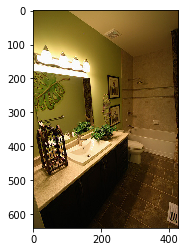

Decoded sentence:  a bathroom with a toilet and a sink 

Should be: ['\t', 'a', 'bathroom', 'with', 'a', 'large', 'mirror', 'above', 'a', 'white', 'sink', '\n']


/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU: 0.816496580927726
-
Input:


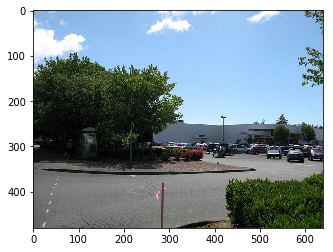

Decoded sentence:  a man is standing on a street with a sign 

Should be: ['\t', 'a', 'parking', 'lot', 'filled', 'with', 'parked', 'cars', 'in', 'a', 'shopping', 'center', '\n']
BLEU: 0.7765453555044466
-
Input:


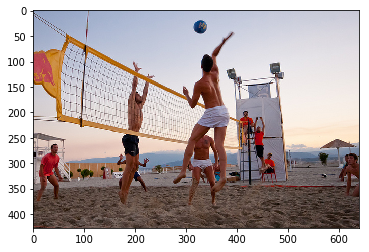

Decoded sentence:  a man riding a wave on top of a surfboard 

Should be: ['\t', 'there', 'are', 'many', 'people', 'inn', 'the', 'beach', 'playing', 'volley', 'ball', '\n']
BLEU: 0.7765453555044466
-
Input:


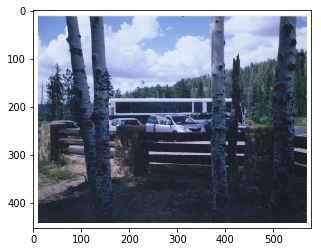

Decoded sentence:  a red and white bus traveling down a street 

Should be: ['\t', 'a', 'bus', 'and', 'some', 'cars', 'at', 'a', 'park', 'like', 'setting', '\n']
BLEU: 0.7400828044922853
-
Input:


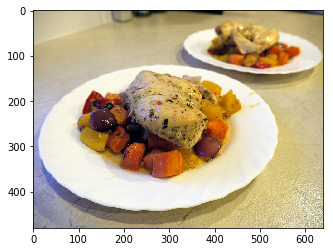

Decoded sentence:  a plate of food with a sandwich and a fork on it 

Should be: ['\t', 'two', 'big', 'plates', 'filled', 'with', 'some', 'tasty', 'looking', 'food', '\n']
BLEU: 0.7447819789879647
-
Input:


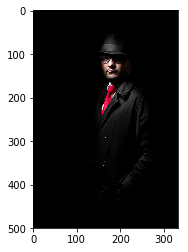

Decoded sentence:  a man is holding a tennis racquet on a tennis court
Should be: ['\t', 'a', 'nearly', 'all', 'black', 'snapshot', 'shows', 'a', 'man', 'standing', 'sideways', 'and', 'looking', 'forward', 'who', 'is', 'wearing', 'a', 'dark', 'coat', 'and', 'hat', 'and', 'a', 'bright', 'pink', 'tie', '\n']
BLEU: 0.7226568811456053
-
Input:


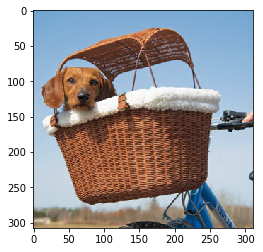

Decoded sentence:  a dog is sitting on a bench in the sand 

Should be: ['\t', 'a', 'dog', 'rests', 'in', 'a', 'basket', 'on', 'a', 'bike', '\n']
BLEU: 0.7226568811456053
-
Input:


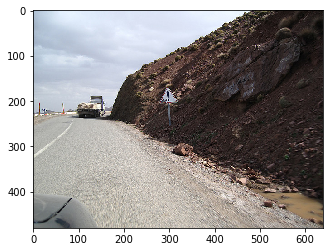

Decoded sentence:  a man riding skis down a snow covered slope 

Should be: ['\t', 'a', 'treacherous', 'road', 'next', 'to', 'a', 'rocky', 'cliff', 'is', 'shown', '\n']
BLEU: 0.7400828044922853
-
Input:


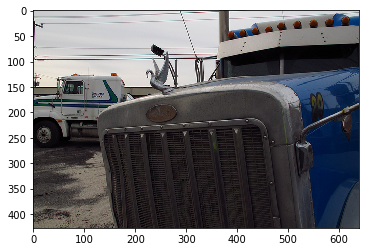

Decoded sentence:  a red and white bus traveling down a street 

Should be: ['\t', 'two', 'big', 'trucks', 'are', 'parked', 'in', 'a', 'parking', 'lot', '\n']
BLEU: 0.7400828044922853
-
Input:


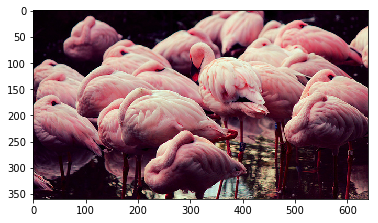

Decoded sentence:  a man is holding a banana in his hand 

Should be: ['\t', 'a', 'flock', 'of', 'pink', 'flamingos', 'stand', 'with', 'their', 'heads', 'resting', 'on', 'their', 'backs', '\n']
BLEU: 0.7400828044922853
-
Input:


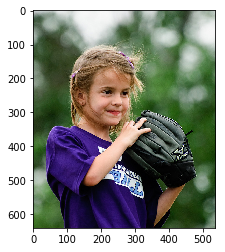

Decoded sentence:  a man is holding a tennis racquet on a tennis court
Should be: ['\t', 'a', 'girl', 'smiles', 'while', 'holding', 'a', 'baseball', 'glove', '\n']
BLEU: 0.7226568811456053
-
Input:


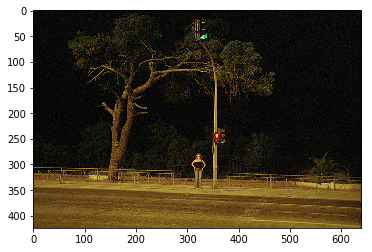

Decoded sentence:  a man riding a skateboard down a street 

Should be: ['\t', 'a', 'person', 'standing', 'on', 'a', 'side', 'walk', 'underneath', 'a', 'traffic', 'light', '\n']
BLEU: 0.816496580927726
-
Input:


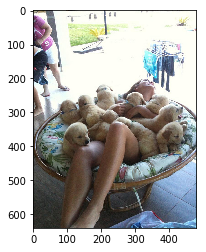

Decoded sentence:  a man sitting on a bench with a dog in his mouth 

Should be: ['\t', 'a', 'woman', 'is', 'laying', 'down', 'with', 'several', 'puppies', '\n']
BLEU: 0.7447819789879647
-
Input:


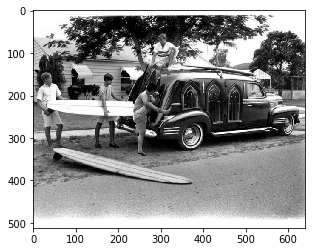

Decoded sentence:  a man riding a skateboard on top of a ramp 

Should be: ['\t', 'black', 'and', 'white', 'photograph', 'of', 'people', 'with', 'surfboards', 'next', 'to', 'a', 'car', '\n']
BLEU: 0.7765453555044466
-
Input:


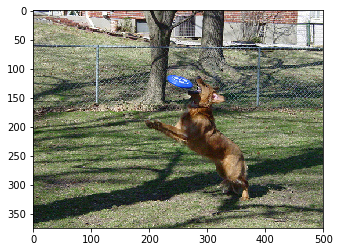

Decoded sentence:  a giraffe standing in a field of grass 

Should be: ['\t', 'the', 'dog', 'is', 'playing', 'catch', 'with', 'his', 'master', '\n']
BLEU: 0.7598356856515925
-
Input:


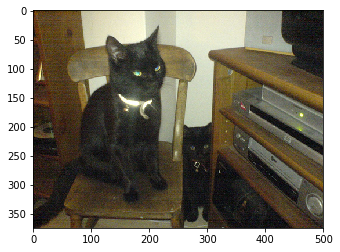

Decoded sentence:  a man is sitting on a couch with a laptop computer 

Should be: ['\t', 'two', 'black', 'cats', 'one', 'sitting', 'on', 'a', 'chair', 'and', 'one', 'next', 'to', 'the', 'chair', '\n']
BLEU: 0.7598356856515925
-
Input:


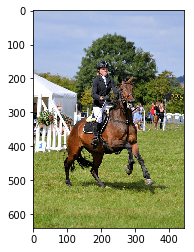

Decoded sentence:  a man riding a horse in a field with a surfboard 

Should be: ['\t', 'the', 'woman', 'prepares', 'her', 'horse', 'for', 'a', 'jumping', 'competition', '\n']
BLEU: 0.8034284189446518
-
Input:


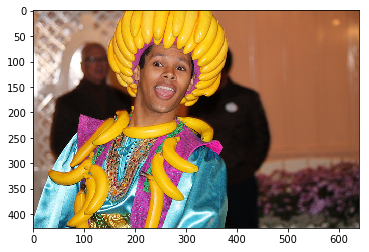

Decoded sentence:  a man is sitting at a table with a plate of food 

Should be: ['\t', 'a', 'man', 'in', 'hat', 'made', 'of', 'bananas', 'standing', 'in', 'room', 'by', 'men', '\n']
BLEU: 0.7447819789879647
-
Input:


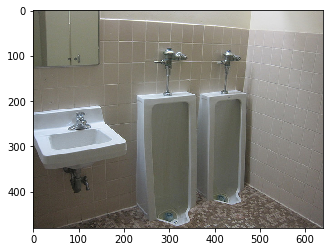

Decoded sentence:  a white toilet sitting next to a sink in a bathroom
Should be: ['\t', 'this', 'mens', 'bathroom', 'has', 'two', 'urinals', 'and', 'a', 'sinks', '\n']
BLEU: 0.7226568811456053
-
Input:


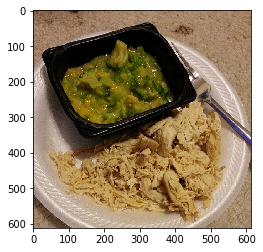

Decoded sentence:  a plate of food with a sandwich and a fork on it 

Should be: ['\t', 'the', 'meal', 'consists', 'of', 'chopped', 'chicken', 'with', 'cheese', 'and', 'brocolli', '\n']
BLEU: 0.7447819789879647
-
Input:


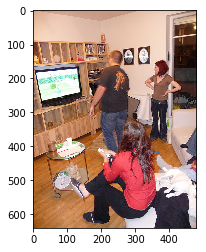

Decoded sentence:  a man sitting on a couch with a laptop computer 

Should be: ['\t', 'a', 'group', 'of', 'people', 'in', 'a', 'room', 'with', 'remotes', '\n']
BLEU: 0.7765453555044466
-
Input:


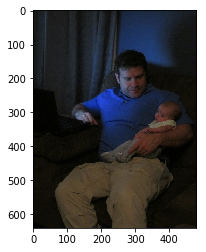

Decoded sentence:  a man is holding a dog and a dog 

Should be: ['\t', 'a', 'man', 'holding', 'a', 'baby', 'in', 'a', 'chair', '\n']
BLEU: 0.7952707287670506
-
Input:


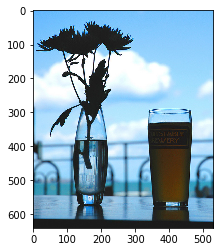

Decoded sentence:  a man riding a bike down a street next to a building
Should be: ['\t', 'a', 'glass', 'and', 'vase', 'sit', 'on', 'a', 'table', 'overlooking', 'the', 'ocean', '\n']
BLEU: 0.7598356856515925
-
Input:


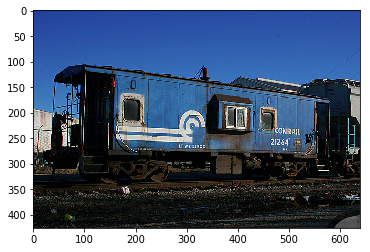

Decoded sentence:  a train traveling down a train track next to a forest
Should be: ['\t', 'the', 'large', 'blue', 'train', 'is', 'covered', 'with', 'rust', '\n']
BLEU: 0.7226568811456053
-
Input:


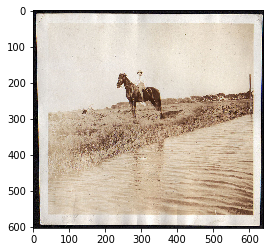

Decoded sentence:  a man riding a wave on top of a surfboard 

Should be: ['\t', 'this', 'person', 'is', 'riding', 'their', 'horse', 'near', 'the', 'water', '\n']
BLEU: 0.7765453555044466
-
Input:


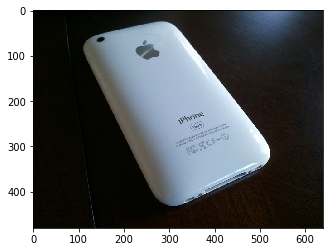

Decoded sentence:  a white toilet sitting next to a white sink 

Should be: ['\t', 'the', 'back', 'view', 'of', 'white', 'iphone', 'mobile', 'phone', '\n']
BLEU: 0.7400828044922853
-
Input:


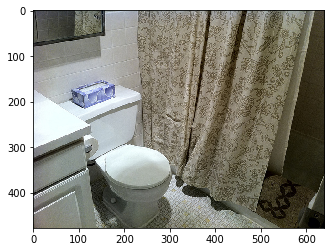

Decoded sentence:  a bathroom with a toilet and a sink 

Should be: ['\t', 'a', 'white', 'toilet', 'with', 'a', 'box', 'of', 'tissues', 'on', 'its', 'tank', '\n']
BLEU: 0.816496580927726
-
Input:


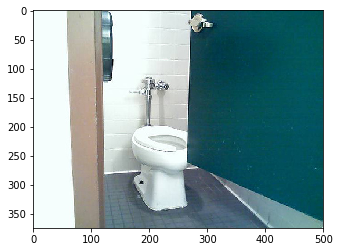

Decoded sentence:  a white toilet sitting next to a white toilet 

Should be: ['\t', 'bathroom', 'stall', 'with', 'green', 'door', 'in', 'commercial', 'business', '\n']
BLEU: 0.7400828044922853
-
Input:


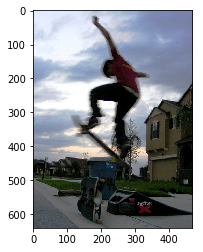

Decoded sentence:  a man is standing on a street with a sign 

Should be: ['\t', 'a', 'person', 'on', 'a', 'skateboard', 'does', 'an', 'air', 'trick', '\n']
BLEU: 0.7765453555044466
-
Input:


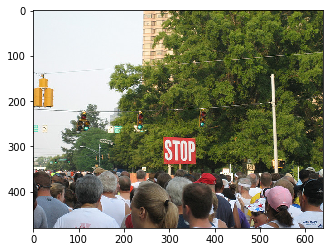

Decoded sentence:  a man is standing on a street with a sign 

Should be: ['\t', 'people', 'stand', 'in', 'a', 'city', 'street', 'at', 'a', 'rally', '\n']
BLEU: 0.7765453555044466
-
Input:


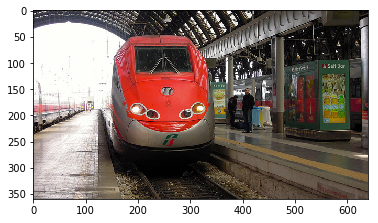

Decoded sentence:  a red and white bus traveling down a street 

Should be: ['\t', 'a', 'train', 'pulls', 'up', 'as', 'a', 'man', 'stands', 'waiting', 'alongside', 'snack', 'machines', '\n']
BLEU: 0.7400828044922853
-
Input:


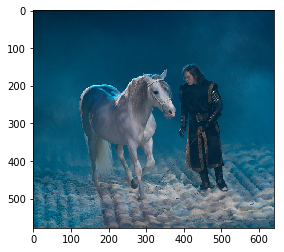

Decoded sentence:  a man riding a skateboard on top of a cement ramp 

Should be: ['\t', 'a', 'man', 'in', 'black', 'leading', 'an', 'all', 'white', 'horse', '\n']
BLEU: 0.7598356856515925


In [14]:
model.save_weights('img2seq_weight.h5')
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)


encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)
reverse_word_index=dict((i,char) for char,i in token.items())

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,seq_len))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = tokens['\t']
    target_seq_index=0
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    decoded_sequence=[]
    while not stop_condition:
        output_tokens_index, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_word_index[sampled_token_index]
        decoded_sentence += (" "+sampled_char)
        decoded_sequence.append(sampled_char)
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > seq_len):
            stop_condition = True
        target_seq_index+=1
        # Update the target sequence (of length 1).
        target_seq[0, target_seq_index] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence,decoded_sequence




indices=random.sample(range(len(vali_x_file)),32)
            
for index in indices:
    # Take one sequence (part of the training set)
    # for trying out decoding.
    
    encoder_input_data=np.zeros(
        (1,1,vec_len),dtype='float32'
    )
    encoder_input_data[0][0]=vec_reader(vali_x_file[index]+'.txt')

    
    decoded_sentence,seq = decode_sequence(encoder_input_data)
    print('-')
    print('Input:')
    plt.imshow(np.asarray(Image.open(vali_x_file[index])))
    plt.show()
    print('Decoded sentence:', decoded_sentence)
    print('Should be:',vali_y_seq[index])
    print('BLEU:',sentence_bleu(token, seq))